# What NYC boroughs should we avoid?

## (Or, what borough has the fastest taxi drivers?)

In [1]:
from __future__ import division

In [2]:
import sqlparse


def psql(query):
    print(
        sqlparse.format(
            str(query.compile(
                compile_kwargs=dict(literal_binds=True)
            )),
            reindent=True
        )
    )


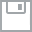
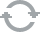
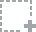
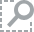
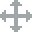
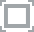
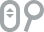
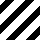
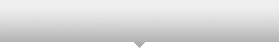
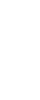
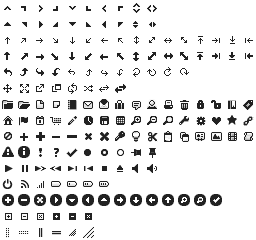
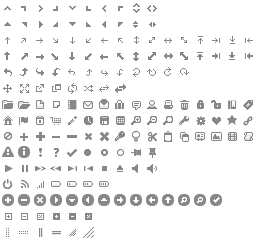
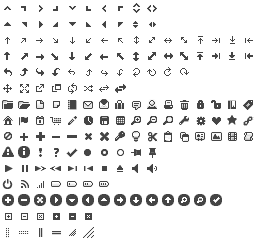
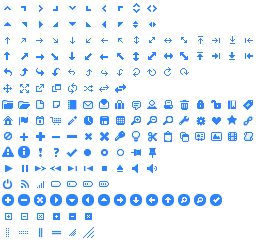
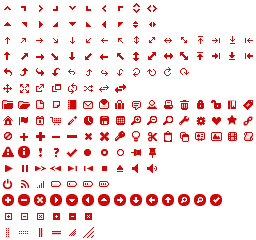
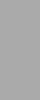
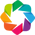
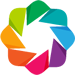

In [46]:
%reload_ext autotime
%matplotlib nbagg

from blaze import by, compute, transform, Data
from odo import odo, drop, resource, Temp, CSV
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from IPython.display import Image
from sqlalchemy import func as f
from bokeh.charts import Histogram
from bokeh.charts import defaults, vplot, hplot, show, output_notebook
output_notebook()

## Load up NYC Taxi from Postgres

In [4]:
d = Data('postgresql://localhost/nyc::bigsample')

time: 41.5 ms


In [5]:
d.head(5)

medallion                      hack_license  \
0  039A16D739D799891C9211A55F731263  F6D14E7742FE7EFFCE16E55CB62274FC   
1  207291076F51439066F4430B049D8E4A  7808B339F91B9527FEC548FC5B92E6A6   
2  DF0002B656F1AA6D651D3EB6C4AD2157  0DD4A4383927098D2CB5A90C049005DE   
3  EBAA2041372A9CEA19CF32572A0D1752  FB7456FD36320B37B976E15D9B41C760   
4  022562E7A0FEB7A9D4A31B06BF0B82E8  B706829B6520B5C6A15EF434DDE3A8D4   

  vendor_id  rate_code store_and_fwd_flag     pickup_datetime  \
0       CMT          1                  N 2013-05-29 08:50:23   
1       CMT          1                  N 2013-05-29 08:42:32   
2       CMT          1                  N 2013-05-29 08:40:50   
3       CMT          1                  N 2013-05-29 08:43:52   
4       CMT          1                  N 2013-05-29 08:42:10   

     dropoff_datetime  passenger_count  trip_time_in_secs  trip_distance  \
0 2013-05-29 09:12:27                1               1322            6.0   
1 2013-05-29 08:51:43                1                550            1.4   
2 2013-05-29 08:58:50                1               1079            2.6   
3 2013-05-29 08:57:20                1                807            1.8   
4 2013-05-29 08:55:02                1                772            1.7   

     ...     pickup_latitude  dropoff_longitude  dropoff_latitude  \
0    ...           40.704449         -73.974663         40.756542   
1    ...           40.734665         -73.982109         40.746216   
2    ...           40.722893         -73.983284         40.754322   
3    ...           40.746155         -73.979820         40.761417   
4    ...           40.786579         -73.966835         40.763958   

   tolls_amount tip_amount total_amount mta_tax fare_amount payment_type  \
0          0.00       2.00        23.50    0.50       21.00          CRD   
1          0.00       1.00         9.50    0.50        8.00          CRD   
2          0.00       2.70        16.20    0.50       13.00          CRD   
3          0.00       2.10        12.60    0.50       10.00          CRD   
4          0.00       2.10        12.60    0.50       10.00          CRD   

  surcharge  
0      0.00  
1      0.00  
2      0.00  
3      0.00  
4      0.00  

[5 rows x 21 columns]

time: 45.6 ms


## What is the bounding box of NYC?

In [6]:
from IPython.display import HTML, IFrame

time: 718 µs


In [7]:
IFrame(
    'https://www.maptechnica.com/us-city-boundary-map/city/New%20York/state/NY/cityid/3651000',
    width=800,
    height=600
)

time: 1.45 ms


## Postgres has some funky operators for doing cool things

In [8]:
!psql nyc -c 'select point(40.477399, -74.259090) <@> point(40.917577, -73.700272) as box_dist'

     box_dist     
------------------
 39.5120219053786
(1 row)

time: 18.7 ms


In [9]:
max_distance = d.data.bind.execute(
    sa.select([
        f.point(40.477399, -74.259090).op('<@>')(f.point(40.917577, -73.700272))
    ])
).scalar()
max_distance

39.5120219053786

time: 5.81 ms


## Reduce the data to the area defined as NYC

In [10]:
# http://hafen.github.io/taxi/#reading-in-to-r

min_lat, max_lat = 40.477399, 40.917577
min_lon, max_lon = -74.259090, -73.700272

valid = d[
  (d.trip_distance > 0) &
  (d.trip_distance <= max_distance) &
  (d.trip_time_in_secs > 0) &
  (d.passenger_count > 0) & (d.passenger_count <= 5) &
  (d.pickup_latitude >= min_lat) & (d.pickup_latitude <= max_lat) &
  (d.dropoff_latitude >= min_lat) & (d.dropoff_latitude <= max_lat) &
  (d.pickup_longitude >= min_lon) & (d.pickup_longitude <= max_lon) &
  (d.dropoff_longitude >= min_lon) & (d.dropoff_longitude <= max_lon)
]

time: 196 ms


In [11]:
psql(compute(valid))

SELECT bigsample.medallion,
       bigsample.hack_license,
       bigsample.vendor_id,
       bigsample.rate_code,
       bigsample.store_and_fwd_flag,
       bigsample.pickup_datetime,
       bigsample.dropoff_datetime,
       bigsample.passenger_count,
       bigsample.trip_time_in_secs,
       bigsample.trip_distance,
       bigsample.pickup_longitude,
       bigsample.pickup_latitude,
       bigsample.dropoff_longitude,
       bigsample.dropoff_latitude,
       bigsample.tolls_amount,
       bigsample.tip_amount,
       bigsample.total_amount,
       bigsample.mta_tax,
       bigsample.fare_amount,
       bigsample.payment_type,
       bigsample.surcharge
FROM bigsample
WHERE bigsample.trip_distance > 0
  AND bigsample.trip_distance <= 39.5120219053786
  AND bigsample.trip_time_in_secs > 0
  AND bigsample.passenger_count > 0
  AND bigsample.passenger_count <= 5
  AND bigsample.pickup_latitude >= 40.477399
  AND bigsample.pickup_latitude <= 40.917577
  AND bigsample.dropoff_latitude

## Add a column containing the average speed in MPH

In [12]:
trip_time_in_hours = valid.trip_time_in_secs.coerce('float64') / 3600.0
calcd = transform(valid, avg_speed_in_mph=valid.trip_distance / trip_time_in_hours)

time: 8.07 ms


In [13]:
calcd.avg_speed_in_mph.head(5)

avg_speed_in_mph
0         16.338880
1          9.163636
2          8.674699
3          8.029740
4          7.927461

time: 191 ms


In [14]:
s = odo(calcd.avg_speed_in_mph, pd.Series)

time: 40.3 s


In [55]:
show(Histogram(
    s.loc[s > 120],
    title='Average Speed in MPH',
    bins=100,
    xlabel='Average Speed in MPH',
    ylabel='Count'
))

time: 2.37 s


In [ ]:
p = Scatter(df, x='mpg', y='hp', color='cyl', title="HP vs MPG (shaded by CYL)",
            xlabel="Miles Per Gallon", ylabel="Horsepower")

### Assume that > 120 MPH is invalid

In [16]:
data = calcd[(calcd.avg_speed_in_mph > 5) & (calcd.avg_speed_in_mph <= 120)][
    [
        'avg_speed_in_mph', 
        'pickup_latitude', 
        'pickup_longitude', 
        'dropoff_latitude', 
        'dropoff_longitude'
    ]
]

time: 45.6 ms


In [17]:
data.head(5)

avg_speed_in_mph  pickup_latitude  pickup_longitude  dropoff_latitude  \
0         16.338880        40.704449        -74.009140         40.756542   
1          9.163636        40.734665        -73.998756         40.746216   
2          8.674699        40.722893        -74.008110         40.754322   
3          8.029740        40.746155        -73.997772         40.761417   
4          7.927461        40.786579        -73.950813         40.763958   

   dropoff_longitude  
0         -73.974663  
1         -73.982109  
2         -73.983284  
3         -73.979820  
4         -73.966835

time: 378 ms


In [18]:
psql(compute(data))

SELECT bigsample.trip_distance / (CAST(bigsample.trip_time_in_secs AS FLOAT) / 3600.0) AS avg_speed_in_mph,
       bigsample.pickup_latitude,
       bigsample.pickup_longitude,
       bigsample.dropoff_latitude,
       bigsample.dropoff_longitude
FROM bigsample
WHERE bigsample.trip_distance > 0
  AND bigsample.trip_distance <= 39.5120219053786
  AND bigsample.trip_time_in_secs > 0
  AND bigsample.passenger_count > 0
  AND bigsample.passenger_count <= 5
  AND bigsample.pickup_latitude >= 40.477399
  AND bigsample.pickup_latitude <= 40.917577
  AND bigsample.dropoff_latitude >= 40.477399
  AND bigsample.dropoff_latitude <= 40.917577
  AND bigsample.pickup_longitude >= -74.25909
  AND bigsample.pickup_longitude <= -73.700272
  AND bigsample.dropoff_longitude >= -74.25909
  AND bigsample.dropoff_longitude <= -73.700272
  AND bigsample.trip_distance / (CAST(bigsample.trip_time_in_secs AS FLOAT) / 3600.0) > 5
  AND bigsample.trip_distance / (CAST(bigsample.trip_time_in_secs AS FLOAT) / 3600.

## A small aside, with `odo`

### Let's look at the distribution of rides by borough

#### Q: Where do we get borough geolocation data?
#### A: From NYC's own API!

In [19]:
import requests

time: 565 µs


In [20]:
def get_kml(wifi):
    if wifi:
        result = requests.get(
            'https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm',
            params=dict(method='export', format='KML')
        ).text
        with open('cityofnewyork.kml', 'wt') as f:
            f.write(result)
        return result
    else:
        with open('cityofnewyork.kml', 'rt') as f:
            return f.read()

time: 2.76 ms


In [21]:
raw = get_kml(wifi=False)

time: 2.83 ms


In [22]:
import lxml
import lxml.etree

time: 8.91 ms


#### Parse the KML with `lxml`

In [23]:
kml = lxml.etree.fromstring(raw.encode('utf8'))

time: 4.92 ms


In [24]:
print(raw[:1000])

<?xml version="1.0" encoding="UTF-8"?><kml xmlns="http://www.opengis.net/kml/2.2" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.opengis.net/kml/2.2 http://schemas.opengis.net/kml/2.2.0/ogckml22.xsd">
   <Document xmlns:atom="http://purl.org/atom/ns#">
      <name>geo_tqmj-j8zm:geo_tqmj-j8zm-1</name>
      <LookAt>
         <longitude>-73.97867494308187</longitude>
         <latitude>40.70615701593643</latitude>
         <altitude>81791.8316066984</altitude>
         <range>66092.09005639808</range>
         <tilt>0.0</tilt>
         <heading>0.0</heading>
         <altitudeMode>clampToGround</altitudeMode>
      </LookAt>
      <Placemark id="geo_tqmj-j8zm-1.1">
         <name><![CDATA[geo_tqmj-j8zm-1.1]]></name>
         <description><![CDATA[<h4>geo_tqmj-j8zm-1</h4>

<ul class="textattributes">
  
  <li><strong><span class="atr-name">BoroCode</span>:</strong> <span class="atr-value">5</span></li>
  <li><strong><span class="atr-name">BoroName</sp

#### `Placemark` elements delineate boroughs

In [25]:
placemarks = kml.xpath("//*[local-name()='Placemark']")

time: 1.62 ms


#### Create some functions to pull out the borough names and points

In [26]:
from toolz.curried import map
from toolz import pipe, concat

import io


def find_borough_name(text):
    return re.search(r'.*(Brooklyn|Manhattan|Bronx|Staten Island|Queens).*', text).group(1)


def parse_coords(p, name):
    coords = p.xpath('.//*[local-name()="coordinates"]/text()')
    return pipe(
        coords,
        map(str.split),
        map(lambda x: '\n'.join(map(lambda y: '%s,%s' % (y, name), x))),
        '\n'.join
    )


def parse_kml(placemarks):
    result = []
    
    for p in placemarks:
        desc, = p.xpath(".//*[local-name()='description']")
        name = find_borough_name(desc.text)        
        result.append(parse_coords(p, name))
    return '\n'.join(result)

time: 8.83 ms


#### Parse the location data

In [27]:
geodata = parse_kml(placemarks)

time: 39.9 ms


In [28]:
geodata[:geodata.find('\n')]

'-74.15340460608331,40.58083062671828,Staten Island'

time: 1.86 ms


#### Inspect our data with pandas

In [29]:
df = pd.read_csv(
    io.StringIO(geodata),
    names=['lon', 'lat', 'name']
).drop_duplicates().reset_index(drop=True)

time: 66.3 ms


In [30]:
df.describe()

lon           lat
count  36999.000000  36999.000000
mean     -73.905210     40.674753
std        0.123101      0.102569
min      -74.255600     40.496100
25%      -73.943300     40.598200
50%      -73.878900     40.632800
75%      -73.815600     40.777900
max      -73.700000     40.915500

time: 14.9 ms


In [31]:
import seaborn as sns

time: 127 ms


In [ ]:
p = Scatter(
    df, x='lon', y='lat',
    color='name',
    title="NYC Borough Polygons"
    xlabel="Longitude", ylabel="Horsepower"
)
output_notebook()
show(p)

#### After we're satisfied, let's throw everything into postgres for later analysis

In [33]:
boros = odo(
    odo(df, Temp(CSV)),
    'postgresql://localhost/nyc::boros'
)

time: 170 ms


In [34]:
Data(boros).head(5)

lon        lat           name
0 -74.153405  40.580831  Staten Island
1 -74.050500  40.566400  Staten Island
2 -74.050300  40.566400  Staten Island
3 -74.050100  40.566400  Staten Island
4 -74.050000  40.566400  Staten Island

time: 15.6 ms


#### Make a table of `name`, `polygon` for each borough

In [35]:
bounds = sa.select([
    boros.c.name,
    f.box(
        f.point(f.min(boros.c.lon), f.min(boros.c.lat)),
        f.point(f.max(boros.c.lon), f.max(boros.c.lat))
    ).label('boro_box')
]).group_by(boros.c.name).alias()

time: 2.45 ms


#### Get out the SQLAlchemy table

In [36]:
data.head(5)

avg_speed_in_mph  pickup_latitude  pickup_longitude  dropoff_latitude  \
0         16.338880        40.704449        -74.009140         40.756542   
1          9.163636        40.734665        -73.998756         40.746216   
2          8.674699        40.722893        -74.008110         40.754322   
3          8.029740        40.746155        -73.997772         40.761417   
4          7.927461        40.786579        -73.950813         40.763958   

   dropoff_longitude  
0         -73.974663  
1         -73.982109  
2         -73.983284  
3         -73.979820  
4         -73.966835

time: 427 ms


In [37]:
nyc = compute(data).alias()

time: 187 ms


#### Join on both the pickup and dropoff latitude and longtiude being in the same borough

In [38]:
joined = nyc.join(
    bounds,
    onclause=f.lseg(
        f.point(nyc.c.pickup_longitude, nyc.c.pickup_latitude),
        f.point(nyc.c.dropoff_longitude, nyc.c.dropoff_latitude)
    ).op('<@')(bounds.c.boro_box)
)

time: 2.7 ms


#### Group By `name` and compute the average speed and the number of samples that went into the average

In [39]:
sel = sa.select([
    bounds.c.name,
    nyc.c.avg_speed_in_mph, 
    nyc.c.pickup_latitude,
    nyc.c.pickup_longitude,
    nyc.c.dropoff_latitude,
    nyc.c.dropoff_longitude
]).select_from(joined).alias()

time: 1.87 ms


In [40]:
per_boro_speeds = sa.select([
    sel.c.name,
    f.avg(sel.c.avg_speed_in_mph).label('avg_speed'),
    f.count(sel.c.avg_speed_in_mph).label('nsamples')
]).group_by(sel.c.name).order_by(sa.desc('avg_speed'))

time: 1.91 ms


In [41]:
psql(per_boro_speeds)

SELECT anon_1.name,
       avg(anon_1.avg_speed_in_mph) AS avg_speed,
       count(anon_1.avg_speed_in_mph) AS nsamples
FROM
  (SELECT anon_2.name AS name,
          anon_3.avg_speed_in_mph AS avg_speed_in_mph,
          anon_3.pickup_latitude AS pickup_latitude,
          anon_3.pickup_longitude AS pickup_longitude,
          anon_3.dropoff_latitude AS dropoff_latitude,
          anon_3.dropoff_longitude AS dropoff_longitude
   FROM
     (SELECT bigsample.trip_distance / (CAST(bigsample.trip_time_in_secs AS FLOAT) / 3600.0) AS avg_speed_in_mph,
             bigsample.pickup_latitude AS pickup_latitude,
             bigsample.pickup_longitude AS pickup_longitude,
             bigsample.dropoff_latitude AS dropoff_latitude,
             bigsample.dropoff_longitude AS dropoff_longitude
      FROM bigsample
      WHERE bigsample.trip_distance > 0
        AND bigsample.trip_distance <= 39.5120219053786
        AND bigsample.trip_time_in_secs > 0
        AND bigsample.passenger_count > 0
  

In [42]:
speeds = odo(per_boro_speeds, pd.DataFrame)
speeds

name  avg_speed  nsamples
0  Staten Island  17.610644        83
1         Queens  16.693146    603622
2          Bronx  16.174595      3475
3       Brooklyn  13.108603   1157388
4      Manhattan  12.787697   7726282

time: 20.2 s


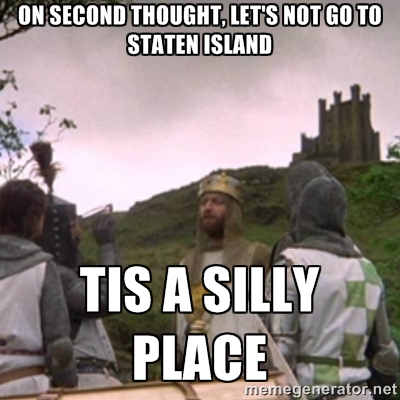

time: 7.2 ms


In [43]:
Image('i.jpg')